## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns
import calendar
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import np_utils
import nltk
import pickle
nltk.download('omw-1.4')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from collections import OrderedDict, Counter
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading data

In [2]:
# Columns to keep
columns = ['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount']

df_train = pd.read_table("data/train.tsv", usecols=columns)
#df_train

In [3]:
df_test = pd.read_table("data/test.tsv", usecols=columns)

# Analyse des données

## Traitement des données

On commence par un traitement pour la variable *date*, qui est de la forme suivannte exemple: 'May, 20, 2012'

In [4]:
    
dic_month={month: index for index, month in enumerate(calendar.month_name) if month}

def get_age(time):
    
    now = datetime.now()
    new = re.sub(r',', '', time)
    new=re.sub(r' ', '-', new)
    for key in dic_month.keys():
        new=re.sub(f"{key}", f"""{dic_month[key]}""", new)
    new=datetime.strptime(new,'%m-%d-%Y')
    assert now.year > new.year
    res=now-new
    return res.days


Cette fonction a pour but de calculer l'âge à partir d'une date donnée.

La fonction prend en entrée une variable "time" qui est une chaîne de caractères représentant une date.
La variable "now" est initialisée avec la date actuelle en utilisant la fonction datetime.now() de la bibliothèque datetime.

Ensuite, la fonction utilise des expressions régulières (re) pour nettoyer la date entrée, en enlevant les virgules et les espaces, et en remplaçant les noms des mois par leurs numéros respectifs grâce à un dictionnaire "dic_month". Cela permet de pouvoir convertir la date entrée au format "mm-jj-aaaa".

Puis, la fonction utilise la fonction datetime.strptime() pour convertir la date nettoyée au format '%m-%d-%Y' qui est utilisable pour les calculs.


Enfin, la fonction calcule la différence entre la date actuelle et la date entrée en utilisant l'opérateur "-" et la propriété "days" de l'objet résultant pour retourner le nombre de jours entre les deux dates.

In [5]:
df_train['date']

0               May 20, 2012
1             April 27, 2010
2          December 14, 2009
3           November 3, 2015
4          November 27, 2016
                 ...        
161292          May 31, 2015
161293      November 1, 2011
161294        March 15, 2014
161295    September 19, 2015
161296     December 13, 2014
Name: date, Length: 161297, dtype: object

In [6]:
df_train

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...
161292,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125
161293,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34
161294,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35
161295,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79


In [7]:
df_train['date'] = df_train['date'].apply(get_age)
df_test['date'] = df_test['date'].apply(get_age)

In [8]:
df_train.fillna('', inplace=True)
df_test.fillna('', inplace=True)
df = pd.concat([df_train, df_test],ignore_index=True)
df = df.drop_duplicates(keep = False)
df = df.reset_index(drop=True)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215059 entries, 0 to 215058
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     215059 non-null  object 
 1   condition    215059 non-null  object 
 2   review       215059 non-null  object 
 3   rating       215059 non-null  float64
 4   date         215059 non-null  int64  
 5   usefulCount  215059 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.8+ MB


In [10]:
def into_int(x):
    return(int(x)-1)

In [11]:
df['rating']=df['rating'].apply(into_int)

In [12]:
set(df['rating'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [13]:
df['len review']=df.review.apply(len)

In [14]:
cont_cols=['rating', 'date', 'usefulCount','len review']
df_cont=df[cont_cols]

In [15]:
df_cont.describe()

,rating,date,usefulCount,len review
count,215059.000000,215059.000000,215059.000000,215059.000000
mean,5.990119,3141.993137,28.001339,458.615961
std,3.275483,987.383526,36.346324,240.994911
min,0.000000,1862.000000,0.000000,3.000000
25%,4.000000,2342.000000,6.000000,262.000000
50%,7.000000,2781.000000,16.000000,456.000000
75%,9.000000,3932.000000,36.000000,690.000000
max,9.000000,5441.000000,1291.000000,10787.000000


## Quelques visualisations

Maintenant nous alons : 

créer un histogramme des valeurs des colonnes de la dataframe "df_cont" à l'aide de la bibliothèque Matplotlib. Le nombre de barres dans l'histogramme est défini à 100.
Un histogramme est une représentation graphique de la distribution d'un ensemble de données. C'est une estimation de la distribution de probabilité d'une variable continue.


En suite la réation d'un diagramme en boîte des valeurs de cette colonne de la dataframe "df_cont" à l'aide de la fonction Dataframe.boxplot().
Un diagramme en boîte, également connu sous le nom de diagramme en boîte à moustaches, est un moyen standardisé de présenter la distribution des données basé sur un résumé à cinq nombres ("minimum", première quartile (Q1), médiane, troisième quartile (Q3) et "maximum"). C'est un moyen standardisé de présenter la distribution d'un ensemble de données, qui permet une comparaison facile entre différents ensembles de données. 

################# rating ################


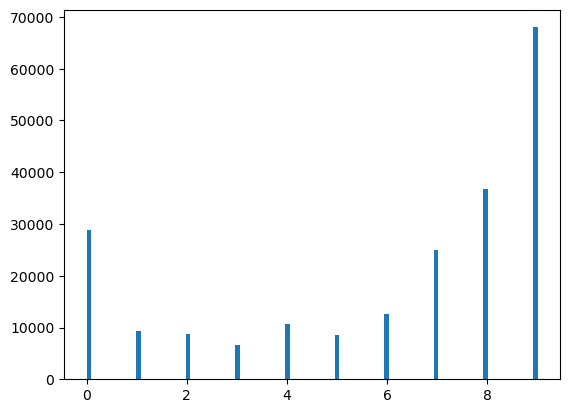

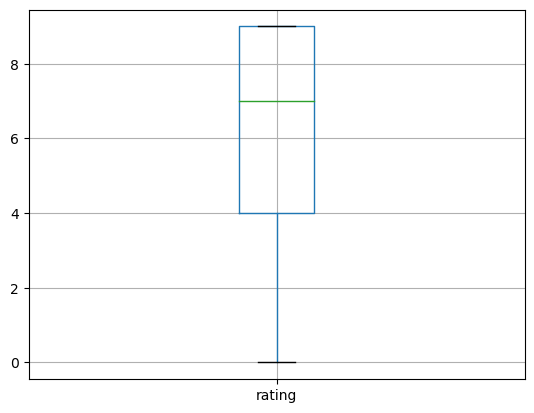

################# date ################


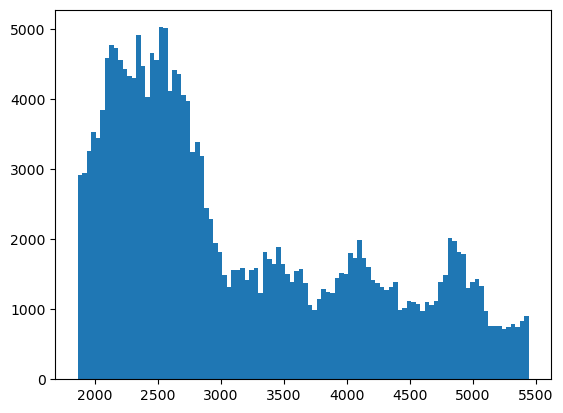

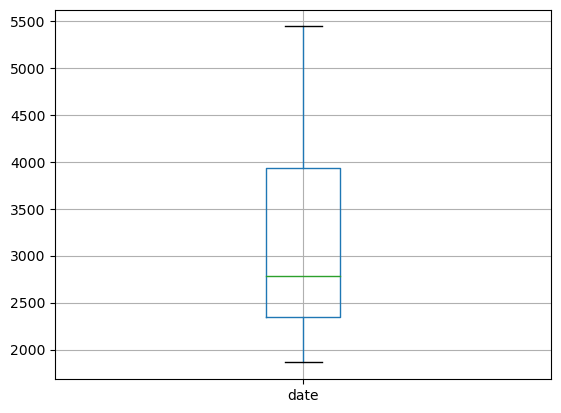

################# usefulCount ################


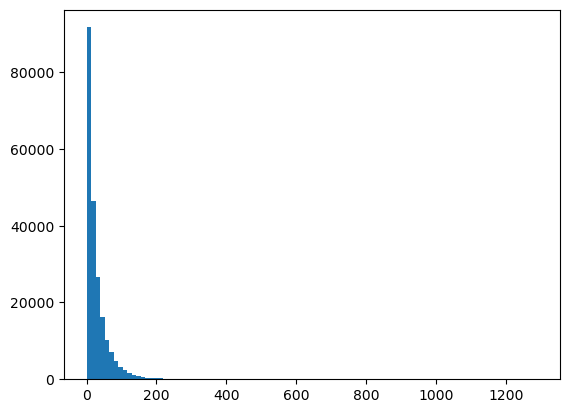

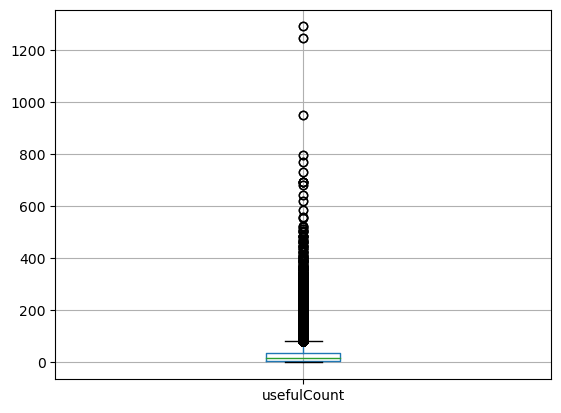

################# len review ################


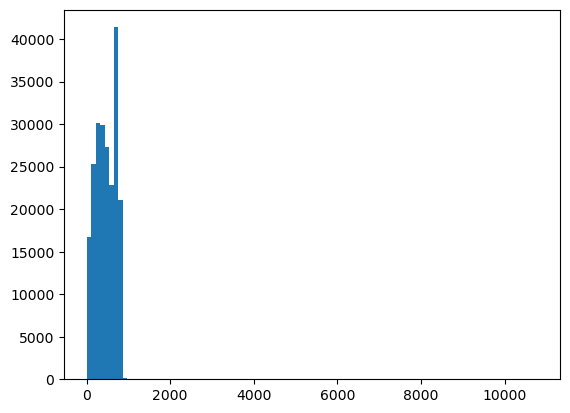

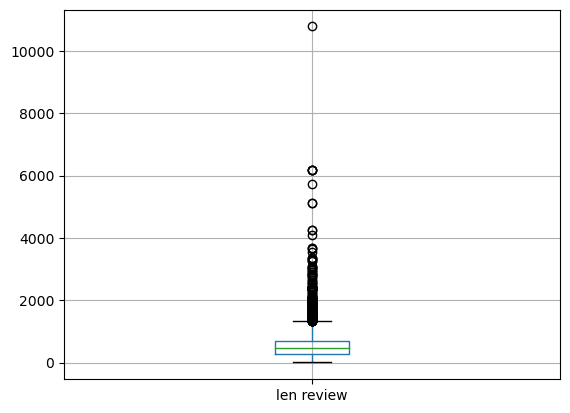

In [16]:
for col in cont_cols:
    print(f"################# {col} ################")
    plt.hist(df_cont[col], bins=100)
    plt.show()
    df_cont.boxplot(column=col)
    plt.show()

               rating      date  usefulCount  len review
rating       1.000000  0.197610     0.234851    0.021732
date         0.197610  1.000000     0.268350   -0.232861
usefulCount  0.234851  0.268350     1.000000    0.025739
len review   0.021732 -0.232861     0.025739    1.000000


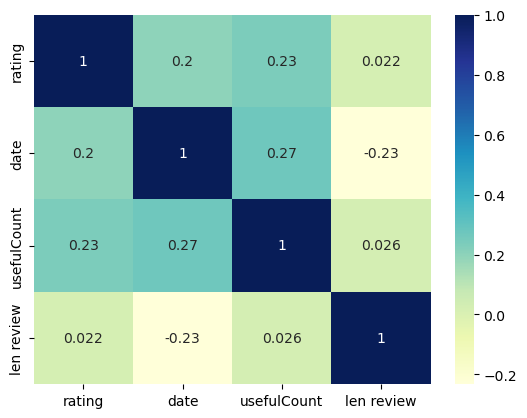

In [17]:
print(df_cont.corr())
  
# plotting correlation heatmap
dataplot = sns.heatmap(df_cont.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

On utilise la fonction *pairplot()* qui permet de visualiser les relations entre différentes variables d'un dataframe en utilisant des graphes de dispersion. Les graphes de dispersion permettent de comprendre comment les variables sont corrélées entre elles. La fonction prend en entrée le dataframe (df_cont) sur lequel on veut effectuer les graphes, avec l'ajout de l'argument "hue" qui permet de visualiser les différentes classes (rating) en utilisant des couleurs différentes pour chaque classe.

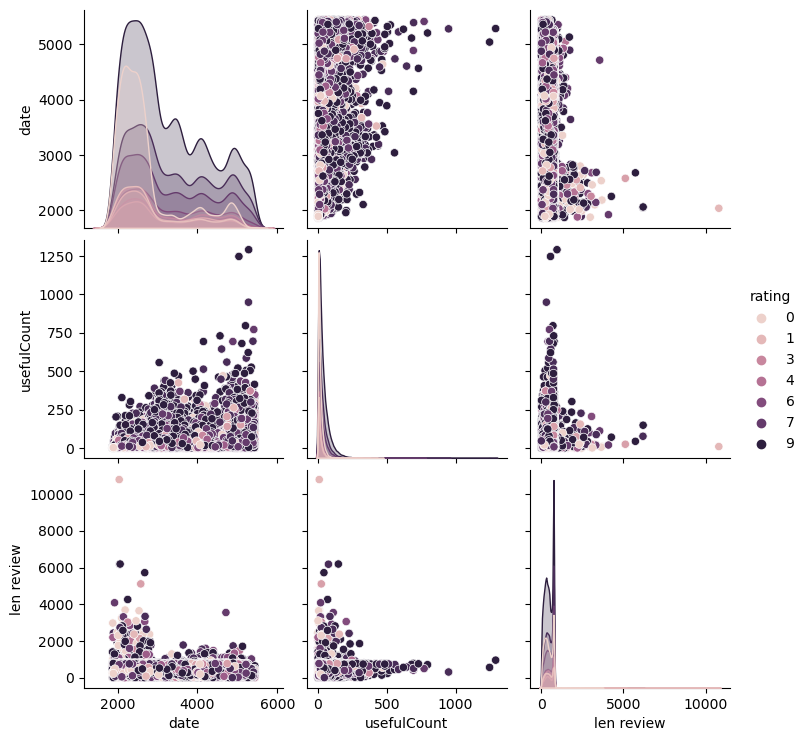

In [18]:
sns.pairplot(data=df_cont, hue="rating")

Le code ci-dessous utilise la fonction *scatterplot()* qui permet de créer un graphe de dispersion pour visualiser comment deux variables sont corrélées entre elles. Il prend en entrée le dataframe (df_cont), les variables x et y qui correspondent aux abscisses et ordonnées du graphe respectivement. Il a également l'argument "hue" qui permet de visualiser les différentes classes (rating) en utilisant des couleurs différentes pour chaque classe.

<AxesSubplot:xlabel='usefulCount', ylabel='len review'>

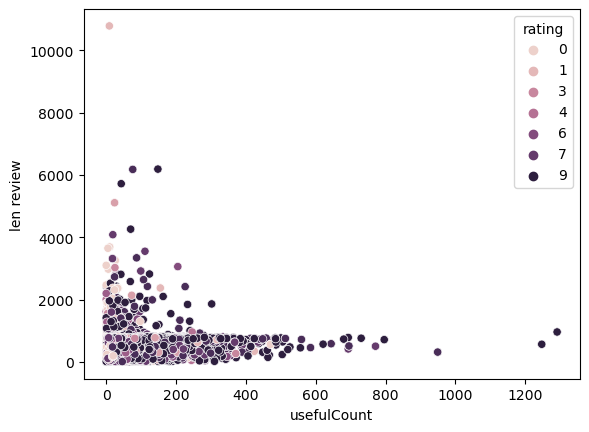

In [19]:
sns.scatterplot(data=df_cont, x="usefulCount", y="len review", hue="rating")

Ce code utilise la fonction jointplot() de la bibliothèque Seaborn pour créer un graphe de dispersion qui visualise la relation entre deux variables dans la dataframe "df_cont", les variables "usefulCount" et "len review", et affiche également des histogrammes des variables individuelles sur les côtés du graphe.

La fonction jointplot() permet de créer un graphe de dispersion pour visualiser comment deux variables sont corrélées entre elles, et d'afficher également des histogrammes des variables individuelles sur les côtés du graphe. Il prend en entrée le dataframe (df_cont), les variables x et y qui correspondent aux abscisses et ordonnées du graphe respectivement. Il a également l'argument "hue" qui permet de visualiser les différentes classes (rating) en utilisant des couleurs différentes pour chaque classe.

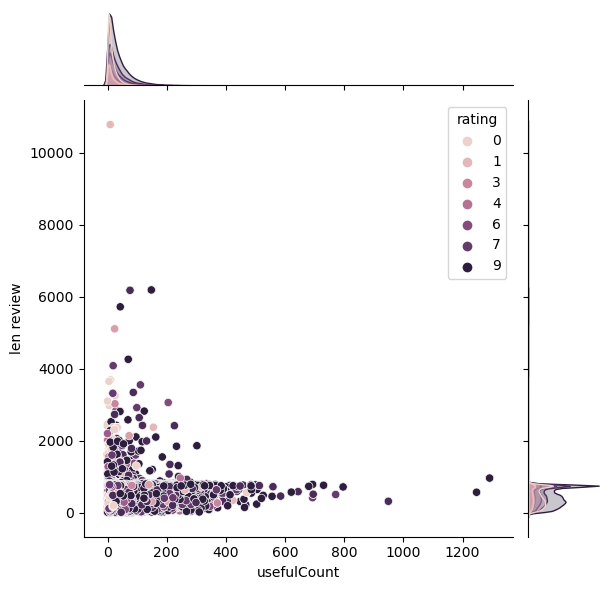

In [20]:
sns.jointplot(data=df_cont, x="usefulCount", y="len review", hue="rating")

# Traitement du texte
Une fois l'ensemble de données analysé, l'étape suivante consiste à prétraiter le texte. Le texte peut contenir des chiffres, des caractères spéciaux et des espaces indésirables. Selon le problème auquel nous sommes confrontés, nous pouvons avoir besoin ou non de supprimer ces caractères spéciaux et ces chiffres du texte. Cependant, pour les besoins de l'explication, nous allons supprimer tous les caractères spéciaux, les chiffres et les espaces indésirables de notre texte. Exécutez le script suivant pour prétraiter les données :



La fonction "nltk.corpus.words.words()" est utilisée pour récupérer une liste de mots standard de la langue anglaise. Cette liste de mots est contenue dans le corpus NLTK "words" qui contient un grand nombre de mots couramment utilisés en anglais.

In [21]:
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()

Ce code définit une fonction "Preprocess_sentence_w_punct" qui prend en entrée une liste de phrases "listofSentence" et retourne une liste de phrases prétraitées.

La fonction crée une liste vide "preprocess_list" qui sera utilisée pour stocker les phrases prétraitées.

La fonction utilise ensuite une boucle "for" pour itérer sur chaque phrase dans la liste d'entrée "listofSentence".
Pour chaque phrase, la fonction utilise une compréhension de liste pour créer une nouvelle chaîne de caractères en mettant tous les caractères en minuscules, et en enlevant les caractères de ponctuation en utilisant la fonction string.punctuation.
La phrase modifiée est ensuite ajoutée à la liste "preprocess_list".

La fonction retourne finalement la liste "preprocess_list" qui contient les phrases prétraitées.
Ce code est utilisé pour prétraiter les phrases en les mettant en minuscules et en enlevant la ponctuation pour faciliter les traitements ultérieurs (comme le traitement automatique du langage).

In [22]:
def Preprocess_sentence_w_punct(listofSentence):
        
    preprocess_list = []

    for sentence in listofSentence :
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        preprocess_list.append(sentence_w_punct)

    return preprocess_list 

Dans ce code one fait  une boucle "for" qui itère sur les colonnes "drugName" et "condition".

Pour chaque colonne, la fonction "Preprocess_sentence_w_punct" est utilisée pour prétraiter les phrases de cette colonne en mettant tous les caractères en minuscules et en enlevant les caractères de ponctuation.

Une nouvelle liste "words_" est ensuite créée pour stocker les mots dans les phrases prétraitées.
La boucle "for" itère sur chaque phrase prétraitée, utilise la fonction split() pour séparer les mots dans chaque phrase, et étend la liste "words_" avec ces mots.

Enfin, la liste "words_" est convertie en ensemble pour enlever les doublons.

Les mots de l'ensemble sont ensuite étendus à la liste "words" en utilisant la méthode "extend()"

finalement de boucle, la liste "words" est convertie en ensemble pour enlever les doublons.

In [23]:
words=list(words)

for col in ['drugName', 'condition']:

    list_sen=Preprocess_sentence_w_punct(df[col])

    words_=[]
    for s in list_sen:
        word_list = s.split()
        words_.extend(word_list)
    words_=list(set(words_))
    words.extend(words_)
    
words=set(words)    

Cette fonction a pour but de prétraiter une liste de phrases "listofSentence" pour les rendre plus propres et plus faciles à traiter pour des analyses ultérieures.

La fonction commence par créer une liste vide "preprocess_list" pour stocker les phrases prétraitées.

Ensuite, il y a une boucle "for" qui itère sur chaque phrase dans la liste d'entrée "listofSentence". Pour chaque phrase :

1. Les caractères de ponctuation sont enlevés en utilisant une compréhension de liste et la fonction string.punctuation.

2. Les chiffres sont enlevés en utilisant une compréhension de liste qui vérifie si chaque caractère est un chiffre avec la fonction isdigit().

3. La phrase est tokenisée en utilisant la fonction word_tokenize() de NLTK pour séparer les mots.

4. Les mots stopwords sont enlevés en utilisant une compréhension de liste qui vérifie si chaque mot est un mot stopword en utilisant la liste "stopwords" importée.

4. Les mots sont lemmatisés en utilisant un objet "lemmatizer" importé pour les ramener à leur forme de base.

5. Les mots non valides sont enlevés en utilisant une compréhension de liste qui vérifie si chaque mot est valide en utilisant l'ensemble "words" crée précédent ou si le mot ne contient pas de caractères alphabétiques avec la fonction isalpha()

6. Les mots propres sont ensuite regroupés en une phrase en utilisant la fonction "join()"

7. La phrase nettoyée est ensuite ajoutée à la liste "preprocess_list"

La fonction retourne finalement la liste "preprocess_list" qui contient les phrases prétraitées.
Ce code est utilisé pour prétraiter les phrases en enlevant la ponctuation, les chiffres, les stopwords, et les mots non valides pour faciliter les traitements ultérieurs (comme l'analyse de sentiments)

In [24]:
def Preprocess_listofSentence(listofSentence):
    
    preprocess_list = []
    for sentence in listofSentence :

        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])

        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())

        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)

        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords]

        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)

        sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in words or not w.isalpha())

        preprocess_list.append(sentence_clean)

    return preprocess_list 

On rajoute des colonnes prétraitées

In [25]:
df['new drugName']=Preprocess_listofSentence(df['drugName'])
df['new condition']=Preprocess_listofSentence(df['condition'])
df['new review']=Preprocess_listofSentence(df['review'])

## Occurrence des mots

Nous allons voir le nombre de fois chaques mots est cité.

In [26]:
df['all text']=df['new drugName']+' '+df['new condition']+' '+df['new review']

In [27]:
all_words=[]
for i in range (len(df)):
    if i !=131531:
        
        rev=df['new review'][i].split()
        drug=df['new drugName'][i].split()
        cond=df['new condition'][i].split()
        
        #print(i)
        
        all_words.extend(rev)
        all_words.extend(drug)
        all_words.extend(cond)
        
        

In [28]:
unique_words=list(set(all_words))

In [29]:
def rep_word(lst, w):
    return lst.count(w)

In [30]:
dic_words={}

# ce bout de code prend beaucoup de temps, le résultat a était enregistré sous un fichier pickle  


#for w in unique_words:

#    dic_words[w]=rep_word(all_words,w)

In [31]:
with open('sorted_dic_words.pickle', 'rb') as handle:
    dic_words = pickle.load(handle)

In [32]:
sort_keys = dic_words.items()
new_items = dict(sorted(sort_keys))

In [33]:
sorted_dic_words = dict(sorted(dic_words.items(), key=lambda x: x[1], reverse=True))

In [34]:
for key in list(sorted_dic_words)[:10]:
    print( key, sorted_dic_words[key])

day 128930
month 92271
year 87929
week 77604
pain 75138
im 74009
effect 73255
side 70474
taking 68242
time 67303


In [35]:
#file_path = 'sorted_dic_words.pickle'


#with open(file_path, 'wb') as handle:
#    pickle.dump(sorted_dic_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
df.columns

Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount',
       'len review', 'new drugName', 'new condition', 'new review',
       'all text'],
      dtype='object')

## Traitements pour les maladies

Maintenant nous allons voir pour chaque maladie la liste des traitements qu'elle a

In [37]:
df.condition.value_counts()

Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Postpartum Breast Pain                              1
Paragonimus westermani, Lung Fluke                  1
unctional Gastric Disorde                           1
Women (minoxidil)                                   1
105</span> users found this comment helpful.        1
Name: condition, Length: 917, dtype: int64

In [38]:
conditions=list(set(df['new condition']))

In [39]:
def traitements(condition,df):
    l=[]
    for i in range (len(df['new condition'])):
        if df['new condition'][i]==condition:
            l.append(df['new drugName'][i])
    return(list(set(l)))
    

In [40]:
l=traitements('adhd',df)
print(len(l),l)

58 ['dyanavel xr', 'methylin er', 'intuniv', 'focalin xr', 'daytrana', 'clonidine', 'amphetamine', 'catapres', 'tenex', 'wellbutrin sr', 'mydayis', 'desvenlafaxine', 'ritalinsr', 'vyvanse', 'selegiline', 'adderall xr', 'omega polyunsaturated fatty acid', 'nuvigil', 'dextroamphetamine', 'focalin', 'dexmethylphenidate', 'guanfacine', 'lisdexamfetamine', 'quillivant xr', 'armodafinil', 'cylert', 'ritalin', 'methamphetamine', 'ritalin la', 'aptensio xr', 'wellbutrin xl', 'adzenys xrodt', 'amantadine', 'modafinil', 'pristiq', 'kapvay', 'evekeo', 'concerta', 'adderall', 'zenzedi', 'budeprion xl', 'strattera', 'bupropion', 'procentra', 'metadate cd', 'desipramine', 'amphetamine dextroamphetamine', 'atomoxetine', 'dexedrine', 'imipramine', 'methylphenidate', 'desoxyn', 'dextrostat', 'provigil', 'metadate er', 'methylin', 'pemoline', 'wellbutrin']


In [41]:
dic_condition_drug={}


# Ce bout de code prend beaucoup de temps, les résultats sont enregistrés sous un fichier.pkl


#for cond in conditions:
#    if cond!='':
#        l=traitements(cond',df)
#        dic_condition_drug[cond]=[len(l),l]

In [42]:
with open('dic_condition_drug.pickle', 'rb') as handle:
    dic_condition_drug = pickle.load(handle)

In [43]:
for key in list(dic_condition_drug)[:10]:
    print( key, dic_condition_drug[key])

mance anxiety [1, ['propranolol']]
hypoestrogenism [9, ['premarin', 'cenestin', 'estradiol patch', 'estrace', 'estrace vaginal cream', 'climara', 'estring', 'conjugated estrogen', 'estradiol']]
cmv prophylaxis [4, ['valacyclovir', 'valganciclovir', 'valcyte', 'valtrex']]
prevention thromboembolism atrial fibrillation [9, ['coumadin', 'warfarin', 'dabigatran', 'apixaban', 'eliquis', 'xarelto', 'pradaxa', 'rivaroxaban', 'jantoven']]
hydrocephalus [1, ['acetazolamide']]
tuberculosis active [1, ['isoniazid']]
hyperphosphatemia [2, ['calcium acetate', 'phoslo']]
thyroid cance [7, ['nexavar', 'armour thyroid', 'cabozantinib', 'cometriq', 'sorafenib', 'thyroid desiccated', 'naturethroid']]
spondyloarthritis [7, ['humira', 'remicade', 'infliximab', 'diclofenac', 'simponi', 'adalimumab', 'golimumab']]
short stature age [1, ['humatrope']]


In [44]:
# Pour enregistrer le dictionnaire


#file_path = 'dic_condition_drug.pickle'


#with open(file_path, 'wb') as handle:
#    pickle.dump(dic_condition_drug, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
dic_condition_drug['dry skin']

[20,
 ['epiceram',
  'lanolin',
  'urea',
  'bag balm',
  'kerafoam',
  'dexpanthenol',
  'lachydrin',
  'eletone',
  'nutraplus',
  'blistex lip balm',
  'amlactin',
  'cetaphil lotion',
  'biafine',
  'xviate',
  'corn huskers lotion',
  'carmol',
  'aveeno',
  'lactic acid',
  'emollient',
  'ammonium lactate']]

# Note moyenne de chaque médicament

In [46]:
def av_rating(trait,df):
    
    m=0
    i=1
    
    for j in range(len(df['new condition'])):
        if trait==df['new drugName'][j]:
            i=i+1
            m=m+df['rating'][j]
    if i!=0:
        return(m/i)
            

In [47]:
av_rating('zofran',df)

7.475609756097561

In [48]:
drugNames=list(set(df['new drugName']))

In [49]:
drugName_rating={}

# Ce bout de code prend beaucoup de temps  

#for drug in drugNames:  

#    drugName_rating[drug]=av_rating(drug,df)

In [50]:
with open('drugName_rating.pickle', 'rb') as handle:
    drugName_rating = pickle.load(handle)

In [51]:
drugName_rating=dict(sorted(drugName_rating.items(), key=lambda x: x[1], reverse=True))

In [52]:
for key in list(drugName_rating)[:10]:
    print( key, drugName_rating[key])

dexbrompheniramine pseudoephedrine 8.781818181818181
drixoral cold allergy 8.76595744680851
silver sulfadiazine 8.625
zelnorm 8.391304347826088
tegaserod 8.391304347826088
cobicistat elvitegravir emtricitabine tenofovir 8.35897435897436
stribild 8.35897435897436
zutripro 8.357142857142858
chlorpheniramine hydrocodone pseudoephedrine 8.357142857142858
elocon 8.31578947368421


In [53]:
#Pour enregistrer le fichier

#file_path = 'drugName_rating.pickle'


#with open(file_path, 'wb') as handle:
#    pickle.dump(drugName_rating, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
df.columns

Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount',
       'len review', 'new drugName', 'new condition', 'new review',
       'all text'],
      dtype='object')

# Convertir du texte en chiffres

Les machines, contrairement aux humains, ne peuvent pas comprendre le texte brut. Les machines ne peuvent voir que des chiffres. En particulier, les techniques statistiques telles que l'apprentissage automatique ne peuvent traiter que des chiffres. Par conséquent, nous devons convertir notre texte en chiffres.

Il existe différentes approches pour convertir le texte en la forme numérique correspondante. Le modèle du sac de mots et le modèle d'incorporation des mots sont deux des approches les plus couramment utilisées. Dans cet article, nous allons utiliser le modèle du sac de mots pour convertir notre texte en chiffres.



## Sac de mots

Le script suivant utilise le modèle de sac de mots pour convertir les documents textuels en caractéristiques numériques correspondantes :

In [55]:
review_lengths = [len(review) for review in df['new review']]
review_length_quartile = np.percentile(review_lengths, 30)

# On filtre le dataset
filtered_dataset = df[df['new review'].apply(lambda x: len(x) < review_length_quartile)]

In [56]:
# traitement des textes
drug_name = filtered_dataset['new drugName'].values
condition = filtered_dataset['new condition'].values
review = filtered_dataset['new review'].values

In [57]:
all_text=filtered_dataset['all text'].values

In [58]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
drug_name = vectorizer.fit_transform(drug_name)
condition = vectorizer.fit_transform(condition)
review = vectorizer.fit_transform(review)

In [59]:
all_text=vectorizer.fit_transform(all_text)

Le script ci-dessus utilise la classe **CountVectorizer** de la bibliothèque **sklearn.feature_extraction.text**. Il y a quelques paramètres importants qui doivent être passés au constructeur de la classe. Le premier paramètre est le paramètre *max_features*, qui est fixé à 1500. En effet, lorsque vous convertissez des mots en nombres en utilisant l'approche du sac de mots, tous les mots uniques de tous les documents sont convertis en caractéristiques. Tous les documents peuvent contenir des dizaines de milliers de mots uniques. Mais les mots qui ont une fréquence d'occurrence très faible ne sont pas, de manière inhabituelle, un bon paramètre pour classer les documents. Par conséquent, nous définissons le paramètre *max_features* à 1500, ce qui signifie que nous voulons utiliser 1500 mots les plus fréquents comme caractéristiques pour l'entraînement de notre classificateur.

Le paramètre suivant est *min_df* et il a été fixé à 5. Cela correspond au nombre minimum de documents qui doivent contenir cette caractéristique. Nous n'incluons donc que les mots qui apparaissent dans au moins 5 documents. De même, pour la caractéristique *max_df*, la valeur est fixée à 0,7 ; dans laquelle la fraction correspond à un pourcentage. Ici, 0,7 signifie que nous devons inclure uniquement les mots qui apparaissent dans un maximum de 70 % de tous les documents. Les mots qui apparaissent dans presque tous les documents ne sont généralement pas adaptés à la classification car ils ne fournissent aucune information unique sur le document.

Enfin, nous supprimons les mots vides de notre texte car, dans le cas de l'analyse des sentiments, les mots vides peuvent ne pas contenir d'informations utiles. Pour supprimer les mots vides, nous passons l'objet stopwords de la bibliothèque **nltk.corpus** au paramètre *stop_words*.

La fonction **fit_transform** de la classe **CountVectorizer** convertit les documents textuels en caractéristiques numériques correspondantes.

# Modèles de prédiction pour la variable : rating

In [60]:
X = np.hstack([drug_name.toarray(), condition.toarray(), review.toarray(), filtered_dataset[['date','usefulCount']].values])


In [61]:


y = filtered_dataset['rating'].values 

# on divise les données selon le ratio len(df_test)/len(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=len(df_test)/len(df), random_state=42)


## RandomForestClassifier

In [62]:


#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test)

#acc = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred, average='weighted')
#print('Test accuracy pour RandomForestClassifier:', acc)
#print('Test F1-score pour RandomForestClassifier:', f1)

In [63]:
#with open('RandomForestClassifier.pkl', 'wb') as f:
#    pickle.dump(clf, f)

In [64]:
with open('RandomForestClassifier.pkl', 'rb') as handle:
    model = pickle.load(handle)

In [65]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Test accuracy pour RandomForestClassifier:', acc)
print('Test F1-score pour RandomForestClassifier:', f1)

Test accuracy pour RandomForestClassifier: 0.7545742107548223
Test F1-score pour RandomForestClassifier: 0.7484892891475271


## DecisionTreeClassifier

In [66]:
#DT_clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

#y_pred = DT_clf.predict(X_test)

#acc = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred, average='weighted')
#print('Test accuracy pour DecisionTreeClassifier:', acc)
#print('Test F1-score pour DecisionTreeClassifier:', f1)

In [67]:
#with open('DecisionTreeClassifier.pkl', 'wb') as f:
#    pickle.dump(DT_clf, f)

In [68]:
with open('DecisionTreeClassifier.pkl', 'rb') as handle:
    model_tree = pickle.load(handle)

In [69]:
y_pred = model_tree.predict(X_test)


acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Test accuracy pour RandomForestClassifier:', acc)
print('Test F1-score pour RandomForestClassifier:', f1)

Test accuracy pour RandomForestClassifier: 0.6756807045835143
Test F1-score pour RandomForestClassifier: 0.6720219565782584


## Deep learning model

In [70]:
DL_model = Sequential()
DL_model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
DL_model.add(Dense(10, activation='softmax'))
DL_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)


#DL_model.fit(X_train, y_train, epochs=10, batch_size=32)


#score = DL_model.evaluate(X_test, y_test)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [71]:
from keras.models import load_model

#DL_model.save("DL_model.h5")

In [72]:
DL_model_= load_model("DL_model.h5")

In [73]:
score = DL_model_.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

504/504 [==============================] - 2s 3ms/step - loss: 2.0298 - accuracy: 0.3676
Test loss: 2.029827833175659
Test accuracy: 0.36761149764060974


## XGBClassifier

In [74]:
X_xg = np.hstack([all_text.toarray(), filtered_dataset[['date','usefulCount']].values])


X_train, X_test, y_train, y_test = train_test_split(X_xg, y, test_size=len(df_test)/len(df), random_state=42)

In [75]:
#xgb_clf=XGBClassifier(booster="gbtree", learning_rate=0.35, n_estimators=5, 
#              max_depth=2, n_jobs=-1, objective="multi:softmax", num_class=10)

#xgb_clf.fit(X_train, y_train)

#y_pred = xgb_clf.predict(X_test)

#acc = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred, average='weighted')
#print('Test accuracy pour XGBClassifier:', acc)
#print('Test F1-score pour XGBClassifier:', f1)

In [76]:
#with open('XGBClassifier.pkl', 'wb') as f:
#    pickle.dump(xgb_clf, f)

In [77]:
with open('XGBClassifier.pkl', 'rb') as handle:
    model_xg = pickle.load(handle)

In [78]:
y_pred = model_xg.predict(X_test)


acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Test accuracy pour RandomForestClassifier:', acc)
print('Test F1-score pour RandomForestClassifier:', f1)

Test accuracy pour RandomForestClassifier: 0.36556472120573097
Test F1-score pour RandomForestClassifier: 0.2199317986850408


## TF-IDF

L'approche du sac de mots fonctionne bien pour convertir du texte en chiffres. Cependant, elle présente un inconvénient. Elle attribue un score à un mot en fonction de son occurrence dans un document particulier. Elle ne tient pas compte du fait que le mot peut également avoir une fréquence d'occurrence élevée dans d'autres documents. TFIDF résout ce problème en multipliant la fréquence des termes d'un mot par la fréquence inverse des documents. TF signifie "fréquence des termes", tandis que IDF signifie "fréquence inverse des documents".

La fréquence des termes est calculée comme suit :

$$TF(w, d) = \frac{n_{w,d}}{\sum_{w' \in d}n_{w',d}}$$

Où :

+$TF(w, d)$ est la fréquence de terme du mot w dans le document d

+$n_{w,d}$ est le nombre d'occurrences du mot w dans le document d

+$d$ est l'ensemble de tous les mots dans le document d

$$IDF(w) = log\left(\frac{N}{n_w}\right)$$

Où :

+$IDF(w)$ est la fréquence inverse de document pour le mot w

+N est le nombre total de documents dans le corpus

+$n_w$ est le nombre de documents contenant le mot w







In [79]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()

drug_name_t = tfidfconverter.fit_transform(drug_name)
condition_t = tfidfconverter.fit_transform(condition)
review_t = tfidfconverter.fit_transform(review)
all_text_t=tfidfconverter.fit_transform(all_text)

In [80]:
X_t = np.hstack([drug_name_t.toarray(), condition_t.toarray(), review_t.toarray(), filtered_dataset[['date','usefulCount']].values])

In [81]:
y = filtered_dataset['rating'].values 

X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=len(df_test)/len(df), random_state=42)

In [82]:
#clf_t = RandomForestClassifier(n_estimators=100, random_state=42)
#clf_t.fit(X_train, y_train)


#y_pred = clf_t.predict(X_test)


#acc = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred, average='weighted')
#print('Test accuracy pour RandomForestClassifier:', acc)
#print('Test F1-score pour RandomForestClassifier:', f1)

In [83]:
#with open('RandomForestClassifier_t.pkl', 'wb') as f:
#    pickle.dump(clf_t, f)

In [84]:
with open('RandomForestClassifier_t.pkl', 'rb') as handle:
    model_t = pickle.load(handle)

In [85]:
y_pred = model_t.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Test accuracy pour RandomForestClassifier:', acc)
print('Test F1-score pour RandomForestClassifier:', f1)

Test accuracy pour RandomForestClassifier: 0.7589158345221113
Test F1-score pour RandomForestClassifier: 0.7530834357327765


In [86]:
#DT_clf_t = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

#y_pred = DT_clf_t.predict(X_test)

#acc = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred, average='weighted')
#print('Test accuracy pour DecisionTreeClassifier:', acc)
#print('Test F1-score pour DecisionTreeClassifier:', f1)

In [87]:
#with open('DecisionTreeClassifier_t.pkl', 'wb') as f:
#    pickle.dump(DT_clf_t, f)

In [88]:
with open('DecisionTreeClassifier_t.pkl', 'rb') as handle:
    model_DT_t = pickle.load(handle)

In [89]:
y_pred = model_DT_t.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Test accuracy pour DecisionTreeClassifier:', acc)
print('Test F1-score pour DecisionTreeClassifier:', f1)

Test accuracy pour DecisionTreeClassifier: 0.6833715809712833
Test F1-score pour DecisionTreeClassifier: 0.6803062528101411


In [90]:
X_xg_t = np.hstack([all_text_t.toarray(), filtered_dataset[['date','usefulCount']].values])

X_train, X_test, y_train, y_test = train_test_split(X_xg_t, y, test_size=len(df_test)/len(df), random_state=42)

In [91]:
#xgb_clf_t=XGBClassifier(booster="gbtree", learning_rate=0.35, n_estimators=5, 
#              max_depth=2, n_jobs=-1, objective="multi:softmax", num_class=10)

#xgb_clf_t.fit(X_train, y_train)

#y_pred = xgb_clf_t.predict(X_test)

#acc = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred, average='weighted')
#print('Test accuracy pour XGBClassifier:', acc)
#print('Test F1-score pour XGBClassifier:', f1)

In [92]:
#with open('XGBClassifier_t.pkl', 'wb') as f:
#    pickle.dump(xgb_clf_t, f)

In [93]:
with open('XGBClassifier_t.pkl', 'rb') as handle:
    model_xg_t = pickle.load(handle)

In [94]:
y_pred = model_xg_t.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Test accuracy pour XGBClassifier:', acc)
print('Test F1-score pour XGBClassifier:', f1)

Test accuracy pour XGBClassifier: 0.3644483036655709
Test F1-score pour XGBClassifier: 0.2178669011348393
